In [437]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
import dask.dataframe as dd
from scipy.stats import norm
from sklearn.cluster import KMeans
import numpy as np
import pandas



/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_26879/3154712075.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [438]:
#load mobility and temperature data
#load heatwave - control dataframe
mobility_heat = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/nigeria/THI_mobility_heat_clean_90.csv')
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/nigeria/THI_heatwave_control_90.csv')

In [439]:
heatwave_control['datetime'].min()

'2022-02-18'

## Build Intensity Variable


In [345]:
full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/THI/nigeria/daily_max_THI.csv')

full_df.rename(columns={'time': 'datetime'}, inplace=True)
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
full_df['day'] = pd.DatetimeIndex(full_df['datetime']).day
full_df['month'] = pd.DatetimeIndex(full_df['datetime']).month
full_df['year'] = pd.DatetimeIndex(full_df['datetime']).year
full_df.month.unique()
full_df = full_df[~full_df['month'].isin([5])]

full_df['location'] = full_df['adm2'] + ', ' + full_df['adm1']
full_df['datetime_ord'] = [date(x,y,z).toordinal() for x,y,z in zip(full_df['year'], full_df['month'], full_df['day'])]


In [346]:
mobility_heat['control_day'] = pd.to_datetime(mobility_heat['control_day'])

In [347]:
#merge temperatures from control day onto mobility heat
mobility_heat = mobility_heat.merge(full_df[['datetime', 'thi', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

In [348]:
(mobility_heat['thi_heat'] - mobility_heat['thi_control']).max()

9.575853771633568

In [349]:
np.corrcoef(mobility_heat['thi_heat'], mobility_heat['thi_control'])


array([[1.        , 0.67823988],
       [0.67823988, 1.        ]])

### Create/explore temperature difference variable

In [350]:
mobility_heat['temp_diff'] = mobility_heat['thi_heat'] - mobility_heat['thi_control']

In [351]:
mobility_heat['temp_diff'].describe()

count    1488.000000
mean        3.364445
std         1.758996
min         0.790854
25%         2.010302
50%         2.886812
75%         4.424974
max         9.575854
Name: temp_diff, dtype: float64

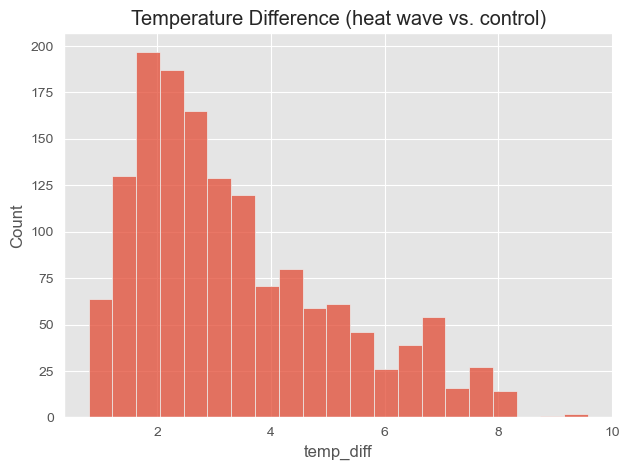

In [352]:
sns.histplot(mobility_heat, x='temp_diff')
plt.title("Temperature Difference (heat wave vs. control)")
plt.tight_layout()
plt.savefig(data_path + '/img/12_09_2023/india_temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build variable showing which day of a heatwave it is

In [353]:
# Formatting column names and merging dataframes

In [354]:
heatwave_control.sort_values(by='Heat Wave Duration', inplace=True)

In [355]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [356]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [357]:
duration_IDs.head()

,heat_ID,Heat Wave Duration
0,5c5f5670-5a05-4cac-a495-22e15d5e3cb2,2.0
4353,dc7ee9b4-2c0d-4b86-bb66-4adbdfbd6969,2.0
4351,942679c7-27da-4691-9985-7ffb4a4977d0,2.0
4349,191350d7-42b7-4aa3-abf1-7f0d7c3726a8,2.0
4345,c33fe6cb-cd7c-4043-9256-d8aa495da992,2.0


In [358]:
duration_IDs['Heat Wave Duration'].describe()

count    2275.000000
mean        4.041758
std         2.815730
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        15.000000
Name: Heat Wave Duration, dtype: float64

In [359]:
#drop original heatwave duration variable
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)

In [360]:
#merge duration ID dataframe onto heatwave control
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')

In [361]:
heatwave_control.drop_duplicates(['location', 'datetime'], inplace=True)

In [362]:
heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [363]:
#groupby each heatwave, sort by date, assign increasing rank for each passing day
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.datetime.sort_values().rank()).reset_index()

In [364]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [365]:
heat_stage['stage'].max()

15.0

In [366]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [367]:
heatwave_control.drop('index', axis=1, inplace=True)

In [368]:
heatwave_control.reset_index(inplace=True)

In [369]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [370]:
heatwave_control['datetime'] = pd.to_datetime(heatwave_control['datetime'])

In [371]:
heatwave_control['stage'].max()

15.0

In [372]:
mobility_heat['date_heat'] = pd.to_datetime(mobility_heat['date_heat'])

In [373]:
#merge temporal variables into mobility_heat

mobility_heat = mobility_heat.merge(heatwave_control[['location', 'datetime', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'datetime'])

In [374]:
mobility_heat.reset_index(inplace=True)

In [375]:
mobility_heat['month'] = [x.month for x in mobility_heat['datetime']]

In [376]:
mobility_heat['month'].unique()

array([3, 4, 2])

In [ ]:
#sorts heatwaves together
unique_IDs = heatwave_control.drop_duplicates('heat_ID')
unique_IDs = unique_IDs[['heat_ID']]

mobility_heat = mobility_heat.merge(unique_IDs, on='heat_ID')

In [377]:
# format final variables
mobility_heat['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration'] )
mobility_heat.drop_duplicates('heat_ID')['Heat Wave Duration'].describe()



count    463.000000
mean       3.444924
std        2.249745
min        2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       12.000000
Name: Heat Wave Duration, dtype: float64

In [378]:
mobility_heat['heatwave_dur'] = mobility_heat['Heat Wave Duration'] >= 4

In [379]:
mobility_heat['month'] = [x.month for x in pd.to_datetime(mobility_heat['date_control'])]

In [380]:
mobility_heat['date_control'] = pd.to_datetime(mobility_heat['date_control'])

In [381]:
mobility_heat['date_control']

0      2022-02-28
1      2022-02-22
2      2022-02-28
3      2022-02-22
4      2022-03-15
          ...    
1483   2022-03-31
1484   2022-03-31
1485   2022-03-25
1486   2022-04-15
1487   2022-04-18
Name: date_control, Length: 1488, dtype: datetime64[ns]

## Merge social and physical variables

In [382]:
soc_phys = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/physical/nigeria/merged.shp')

In [383]:
mobility_heat= mobility_heat.merge(soc_phys[['location', 'mean_elev', 'coast', 'HDI_dec', 'popden_dec', 'over60_dec']], on='location')

In [384]:
mobility_heat['elev_1500m'] = mobility_heat['mean_elev'] >= 1500

In [385]:
mobility_heat['elev_1500m'] = mobility_heat['elev_1500m'] * 1

### Remove holidays 

In [386]:
import requests

In [387]:
hols_2021 = pd.DataFrame(requests.get("https://date.nager.at/api/v3/publicholidays/2021/NG").json())
hols_2022 = pd.DataFrame(requests.get("https://date.nager.at/api/v3/publicholidays/2022/NG").json())
hols = pd.concat([hols_2021, hols_2022])
hols['date'] = pd.to_datetime(hols['date'])

In [388]:
mobility_heat = mobility_heat[~mobility_heat['datetime_heat'].isin(hols['date'].values)]
mobility_heat = mobility_heat[~mobility_heat['datetime_control'].isin(hols['date'].values)]

## Normalized rain variable for heatwave and control day

In [389]:
precip = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/precipitation/nigeria/daily_sum_precipitation.csv')
precip.rename(columns={'valid_time': 'time'}, inplace=True)
precip['time'] = pd.to_datetime(precip['time'])

In [390]:
gdf = gpd.read_file('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/adm0_shp/nigeria/clean_shp.shp')
gdf['location'] = gdf['adm2'] + ', ' + gdf['adm1']
gdf.to_crs(epsg='3857', inplace=True)
gdf['area'] = [x.area for x in gdf['geometry']]

In [391]:
#area from m --> km
#rain from m --> mm
precip['daily_precipitation'] = precip['daily_precipitation'] * 1000
gdf['area'] = gdf['area'] / 1000

In [392]:
precip = precip.merge(gdf[['location', 'area']], on='location')
precip['rain_normed'] = (precip['daily_precipitation'] / precip['area']) 

In [393]:
precip['rain_standard'] = precip.groupby('location')['rain_normed'].rank(pct=True) * 100

### Control day rain dummy

In [394]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['control_day', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [395]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_control"}, inplace=True)

### Heatwave day rain dummy

In [396]:
mobility_heat = mobility_heat.merge(precip[['time', 'adm1', 'adm2', 'rain_standard']], left_on=['date_heat', 'adm1', 'adm2'], right_on=['time', 'adm1', 'adm2'])

In [397]:
mobility_heat.rename(columns={'rain_standard': "rain_standard_heat"}, inplace=True)

### Prepare final dataset

In [412]:
df = mobility_heat.copy()

In [413]:
df = df[df['mean_elev'] <= 2500]

In [414]:
df

,index,Unnamed: 0.1,Unnamed: 0,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
0,0,0,641,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,...,58.500000,0,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670
1,1,1,642,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,...,58.500000,0,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473
2,2,2,929,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,...,57.000000,0,8,10,5,0,2022-02-28,36.813187,2022-03-07,61.538462
3,3,3,930,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,...,57.000000,0,8,10,5,0,2022-02-22,10.989011,2022-03-08,69.780220
4,4,4,951,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,...,57.000000,0,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1481,1481,55162,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,...,539.685723,0,2,4,2,0,2022-03-30,7.967033,2022-04-13,95.604396
1448,1482,1482,55157,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,...,539.685723,0,2,4,2,0,2022-03-31,7.967033,2022-04-07,84.615385
1449,1483,1483,55163,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,...,539.685723,0,2,4,2,0,2022-03-31,7.967033,2022-04-14,96.153846
1450,1484,1484,55168,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,...,539.685723,0,2,4,2,0,2022-03-31,7.967033,2022-04-21,97.802198


In [415]:
#set outlier cutoff (how many SDs away from mean)
SD = 4

In [416]:
df.columns

Index(['index', 'Unnamed: 0.1', 'Unnamed: 0', 'country_region_code',
       'country_region', 'adm1', 'adm2', 'metro_area', 'iso_3166_2_code',
       'census_fips_code', 'place_id', 'date_heat', 'retail_rec_heat',
       'grocery_pharm_heat', 'parks_heat', 'transit_heat', 'workplaces_heat',
       'residential_heat', 'location', 'control_day', 'thi_heat',
       'datetime_heat', 'heat_ID', 'date_control', 'retail_rec_control',
       'grocery_pharm_control', 'parks_control', 'transit_control',
       'workplaces_control', 'residential_control', 'retail_rec_difference',
       'grocery_pharm_difference', 'parks_difference', 'transit_difference',
       'workplaces_difference', 'residential_difference', 'day_of_week',
       'weekend', 'datetime_control', 'thi_control', 'temp_diff', 'datetime',
       'Heat Wave Duration', 'dur_ranking', 'stage', 'month', 'stage_frac',
       'heatwave_dur', 'mean_elev', 'coast', 'HDI_dec', 'popden_dec',
       'over60_dec', 'elev_1500m', 'time_x', 'rain

In [417]:
for variable in ['workplaces_difference', 'residential_difference', 'grocery_pharm_difference', 'parks_difference', 'retail_rec_difference', 'transit_difference']:
    df[variable] = [np.nan if (x >= df[variable].mean() + (SD * df[variable].std())) | (x <= df[variable].mean() - (SD * df[variable].std())) else x for x in df[variable] ]

    #v13
df.dropna(how='all', subset=['workplaces_difference', 'residential_difference', 'transit_difference', 'parks_difference', 'grocery_pharm_difference', 'retail_rec_difference'], inplace=True)

In [418]:
df = df.iloc[:, 3:]

In [419]:
df[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'parks_difference']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
residential_difference,624.0,4.399038,4.132563,-5.0,20.0
workplaces_difference,1388.0,2.293948,15.517929,-64.0,72.0
transit_difference,450.0,4.317778,24.852687,-74.0,92.0
grocery_pharm_difference,416.0,-2.379808,15.403332,-49.0,53.0
retail_rec_difference,358.0,0.748603,19.275198,-55.0,74.0
parks_difference,282.0,-0.535461,25.355981,-100.0,103.0


In [432]:
df

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
0,0,0,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670
1,1,1,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473
2,4,4,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604
3,5,5,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-23,73.076923,2022-03-30,68.681319
4,6,6,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-24,90.659341,2022-03-31,58.791209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,624,629,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-30,7.967033,2022-04-06,61.813187
1440,625,630,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-31,7.967033,2022-04-07,82.417582
1441,627,632,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-25,84.615385,2022-04-08,87.362637
1442,628,633,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-26,17.032967,2022-04-09,7.967033


In [420]:
df.reset_index(inplace=True)

In [421]:
df.sort_values(by=['location', 'heat_ID', 'index'], inplace=True)

In [422]:
df.to_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/nigeria/THI_mobility_heat_w_vars_90_{SD}SD_precip.csv')

In [423]:
df= pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/paper2/nigeria/THI_mobility_heat_w_vars_90_{SD}SD_precip.csv')

In [424]:
ng = pd.read_csv(f'/Users/shivyucel/Documents/projects/DPhil/Code_Data/paper2_repo/__clean/data/nigeria.csv')

In [425]:
df

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
0,0,0,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670
1,1,1,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473
2,4,4,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604
3,5,5,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-23,73.076923,2022-03-30,68.681319
4,6,6,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-24,90.659341,2022-03-31,58.791209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,624,629,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-30,7.967033,2022-04-06,61.813187
1440,625,630,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-31,7.967033,2022-04-07,82.417582
1441,627,632,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-25,84.615385,2022-04-08,87.362637
1442,628,633,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-26,17.032967,2022-04-09,7.967033


In [429]:
pd.concat([ng,df]).drop_duplicates(keep=False)

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
0,0,0,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670
1,1,1,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473
2,2,2,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-02-28,36.813187,2022-03-07,61.538462
3,3,3,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-02-22,10.989011,2022-03-08,69.780220
4,4,4,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,624,629,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-30,7.967033,2022-04-06,61.813187
1440,625,630,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-31,7.967033,2022-04-07,82.417582
1441,627,632,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-25,84.615385,2022-04-08,87.362637
1442,628,633,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-26,17.032967,2022-04-09,7.967033


In [431]:
pd.concat([df, ng]).drop_duplicates(keep=False)

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat,hw_pct,early_hw
0,0,0,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670,NaN,NaN
1,1,1,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473,NaN,NaN
2,4,4,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604,NaN,NaN
3,5,5,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,8,10,5,0,2022-03-23,73.076923,2022-03-30,68.681319,NaN,NaN
4,6,6,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,8,10,5,0,2022-03-24,90.659341,2022-03-31,58.791209,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,1439,1447,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,2,4,2,0,2022-03-30,7.967033,2022-04-13,95.604396,0.537143,0.0
1440,1440,1448,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,2,4,2,0,2022-03-31,7.967033,2022-04-07,84.615385,0.537143,0.0
1441,1441,1449,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,2,4,2,0,2022-03-31,7.967033,2022-04-14,96.153846,0.537143,0.0
1442,1442,1450,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,2,4,2,0,2022-03-31,7.967033,2022-04-21,97.802198,0.876264,0.0


In [430]:
(ng.merge(df, how='outer', indicator=True)
    .loc[lambda d: d.pop('_merge').eq('right_only')]
 )

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
1444,324,327,NG,Nigeria,Ebonyi,Abakaliki,NaN,NaN,NaN,ChIJ5ylIygacXBAR8eiyRp6G1_Q,...,49.351103,0,5,7,3,0,2022-03-29,64.835165,2022-04-05,59.340659
1445,325,328,NG,Nigeria,Ebonyi,Abakaliki,NaN,NaN,NaN,ChIJ5ylIygacXBAR8eiyRp6G1_Q,...,49.351103,0,5,7,3,0,2022-03-30,35.714286,2022-04-06,85.164835
1446,322,325,NG,Nigeria,Ebonyi,Abakaliki,NaN,NaN,NaN,ChIJ5ylIygacXBAR8eiyRp6G1_Q,...,49.351103,0,5,7,3,0,2022-03-18,49.450549,2022-04-01,85.714286
1447,323,326,NG,Nigeria,Ebonyi,Abakaliki,NaN,NaN,NaN,ChIJ5ylIygacXBAR8eiyRp6G1_Q,...,49.351103,0,5,7,3,0,2022-03-26,19.780220,2022-04-02,79.120879
1448,1091,1098,NG,Nigeria,Osun,Aiyedade,NaN,NaN,NaN,ChIJT3nCprm2ORARMhlPxdE4f7E,...,199.125975,0,7,4,9,0,2022-02-28,41.758242,2022-03-07,62.087912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1602,764,769,NG,Nigeria,Kano,Tarauni,NaN,NaN,NaN,ChIJB9QxbsaBrhERTWgDkdxcvgo,...,480.258065,0,3,10,1,0,2022-03-27,27.472527,2022-04-17,57.692308
1603,781,786,NG,Nigeria,Kano,Ungogo,NaN,NaN,NaN,ChIJo6J8QceGrhERNmxir243hO0,...,467.956204,0,3,10,1,0,2022-03-26,18.681319,2022-04-16,98.901099
1604,784,789,NG,Nigeria,Kano,Ungogo,NaN,NaN,NaN,ChIJo6J8QceGrhERNmxir243hO0,...,467.956204,0,3,10,1,0,2022-03-27,27.472527,2022-04-17,58.791209
1605,782,787,NG,Nigeria,Kano,Ungogo,NaN,NaN,NaN,ChIJo6J8QceGrhERNmxir243hO0,...,467.956204,0,3,10,1,0,2022-03-26,18.681319,2022-04-23,44.505495


In [ ]:
df[['residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'parks_difference', 'parks_difference', 'rain_standard_heat']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
residential_difference,624.0,4.399038,4.132563,-5.000000,20.000000
workplaces_difference,1388.0,2.293948,15.517929,-64.000000,72.000000
transit_difference,450.0,4.317778,24.852687,-74.000000,92.000000
grocery_pharm_difference,416.0,-2.379808,15.403332,-49.000000,53.000000
retail_rec_difference,358.0,0.748603,19.275198,-55.000000,74.000000
parks_difference,282.0,-0.535461,25.355981,-100.000000,103.000000
rain_standard_control,1444.0,43.014102,24.495801,0.549451,98.901099


In [314]:
ng[['index', 'residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'transit_difference', 'rain_standard_heat', 'rain_standard_control',
'thi_heat', 'temp_diff', 'heatwave_dur', 'stage_frac', 'weekend', 'popden_dec', 'HDI_dec', 'over60_dec', 'elev_1500m', 'coast']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
index,1444.0,726.502770,419.053472,0.000000,1451.000000
residential_difference,624.0,4.399038,4.132563,-5.000000,20.000000
workplaces_difference,1388.0,2.293948,15.517929,-64.000000,72.000000
transit_difference,450.0,4.317778,24.852687,-74.000000,92.000000
grocery_pharm_difference,416.0,-2.379808,15.403332,-49.000000,53.000000
retail_rec_difference,358.0,0.748603,19.275198,-55.000000,74.000000
transit_difference,450.0,4.317778,24.852687,-74.000000,92.000000
rain_standard_heat,1444.0,72.806764,21.480770,0.549451,100.000000
rain_standard_control,1444.0,43.014102,24.495801,0.549451,98.901099
thi_heat,1444.0,38.654468,1.601258,30.836104,42.386288


In [435]:
df

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
0,0,0,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670
1,1,1,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473
2,4,4,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604
3,5,5,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-23,73.076923,2022-03-30,68.681319
4,6,6,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-24,90.659341,2022-03-31,58.791209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,624,629,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-30,7.967033,2022-04-06,61.813187
1440,625,630,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-31,7.967033,2022-04-07,82.417582
1441,627,632,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-25,84.615385,2022-04-08,87.362637
1442,628,633,NG,Nigeria,Kaduna,Zaria,NaN,NaN,NaN,ChIJ_7yiNKScshERoSJKBIGnTmY,...,646.865672,0,4,9,2,0,2022-03-26,17.032967,2022-04-09,7.967033


In [436]:
ng

,Unnamed: 0,index,country_region_code,country_region,adm1,adm2,metro_area,iso_3166_2_code,census_fips_code,place_id,...,mean_elev,coast,HDI_dec,popden_dec,over60_dec,elev_1500m,time_x,rain_standard_control,time_y,rain_standard_heat
0,0,0,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-28,41.208791,2022-03-07,70.329670
1,1,1,NG,Nigeria,Abia,Aba North,NaN,NaN,NaN,ChIJJ9SHpK2eQhARZRwKEePBcuk,...,58.500000,0,8,10,7,0,2022-02-22,10.439560,2022-03-08,72.527473
2,2,2,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-02-28,36.813187,2022-03-07,61.538462
3,3,3,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-02-22,10.989011,2022-03-08,69.780220
4,4,4,NG,Nigeria,Abia,Aba South,NaN,NaN,NaN,ChIJcXDuChycQhARUr8yL5GPm98,...,57.000000,0,8,10,5,0,2022-03-15,70.879121,2022-03-29,54.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,1439,1447,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,539.685723,0,2,4,2,0,2022-03-30,7.967033,2022-04-13,95.604396
1440,1440,1448,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,539.685723,0,2,4,2,0,2022-03-31,7.967033,2022-04-07,84.615385
1441,1441,1449,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,539.685723,0,2,4,2,0,2022-03-31,7.967033,2022-04-14,96.153846
1442,1442,1450,NG,Nigeria,Zamfara,Gusau,NaN,NaN,NaN,ChIJlyUOw4XCsxERJi_qqjf8lzI,...,539.685723,0,2,4,2,0,2022-03-31,7.967033,2022-04-21,97.802198


In [411]:
df['index']

KeyError: 'index'

In [315]:
df[['index', 'residential_difference', 'workplaces_difference', 'transit_difference', 'grocery_pharm_difference', 'retail_rec_difference', 'transit_difference', 'rain_standard_heat', 'rain_standard_control',
'thi_heat', 'temp_diff', 'heatwave_dur', 'stage_frac', 'weekend', 'popden_dec', 'HDI_dec', 'over60_dec', 'elev_1500m', 'coast']].describe().transpose()[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
index,1444.0,726.503463,419.053212,0.000000,1451.000000
residential_difference,624.0,4.399038,4.132563,-5.000000,20.000000
workplaces_difference,1388.0,2.293948,15.517929,-64.000000,72.000000
transit_difference,450.0,4.317778,24.852687,-74.000000,92.000000
grocery_pharm_difference,416.0,-2.379808,15.403332,-49.000000,53.000000
retail_rec_difference,358.0,0.748603,19.275198,-55.000000,74.000000
transit_difference,450.0,4.317778,24.852687,-74.000000,92.000000
rain_standard_heat,1444.0,72.806764,21.480770,0.549451,100.000000
rain_standard_control,1444.0,43.014102,24.495801,0.549451,98.901099
thi_heat,1444.0,38.654468,1.601258,30.836104,42.386288
